<a href="https://colab.research.google.com/github/DeuklyoungKo/MakeYourFirstGANWithPyTorch/blob/main/ch09_01_face_Convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [2]:
import h5py
import pandas,random, numpy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

import torch
import torch.nn as nn


##Standard CUDA Check And Set Up

In [3]:
# check if CUDA is available
# if yes, set default tensor type to cuda

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

using cuda: Tesla T4


device(type='cuda')

## 데이터셋

In [4]:
class CelebADataset(Dataset):

  def __init__(self, file):
    self.file_object = h5py.File(file, 'r')
    self.dataset = self.file_object['img_align_celeba']
    pass
  
  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    if(index >= len(self.dataset)):
      raise IndexError()
    img = numpy.array(self.dataset[str(index)+'.jpg'])
    # 128x128 이미지로 자르기
    img = crop_centre(img, 128, 128)
    return torch.cuda.FloatTensor(img).permute(2,0,1).view(1,3,128,128) / 255.0

  def plot_image(self, index):
    img = numpy.array(self.dataset[str(index)+'.jpg'])
    # 128x128 이미지로 자르기
    img = crop_centre(img, 128, 128)
    plt.imshow(img, interpolation='nearest')
    pass

  pass

In [6]:
# 중앙르 중심으로 주어진 크기에 맞게 이미지 자르기
def crop_centre(img, new_width, new_height):
  height, width, _ = img.shape
  startx = width//2 - new_width//2
  starty = height//2 - new_height//2
  return img[ starty:starty + new_height, startx:startx + new_width, :]

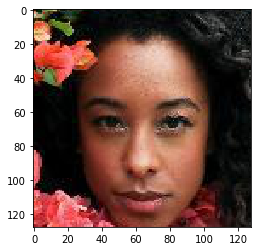

In [7]:
celeba_dataset = CelebADataset('mount/My Drive/Colab Notebooks/Deep Learning/MakeYourFirstGANWithPyTorch/celeba_dataset/celeba_aligned_small.h5py')

celeba_dataset.plot_image(43)

In [8]:
class View(nn.Module):
  def __init__(self, shape):
    super().__init__()
    self.shape = shape,

  def forward(self, x):
    return x.view(*self.shape)

## 판별기

In [9]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    # 신경망 레이어 정의  
    self.model = nn.Sequential(
        
        #(1,3,128,128) 형태

        nn.Conv2d(3, 256, kernel_size=8, stride=2),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 256, kernel_size=8, stride=2),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 3, kernel_size=8, stride=2),
        nn.LeakyReLU(0.2),

        View(3*10*10),
        nn.Linear(3*10*10, 1),
        nn.Sigmoid()
    )

    # 손실함수 설정
    # self.loss_function = nn.MSELoss()
    self.loss_function = nn.BCELoss()

    # SGD 옵티마이저 설정
    # self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
    self.optimiser = torch.optim.Adam(self.parameters(), lr=0.001)

    # 진행 측정을 위한 변수 초기화
    self.counter = 0;
    self.progress = []

    pass

  def forward(self, inputs):
    #모델 실행
    return self.model(inputs)

  def train(self, inputs, targets):
    # 신경망 출력 계산
    outputs = self.forward(inputs)

    # 손실 계산
    loss = self.loss_function(outputs, targets)

    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1;
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if (self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass


    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()
    pass


  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    pass

  def plot_progress2(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
    pass

In [12]:
# 판별기 용
def generate_random_image(size):
  random_data = torch.rand(size).cuda()
  return random_data

# 생성기 용
def generate_random_seed(size):
  random_data = torch.randn(size).cuda()
  return random_data



## 판별기 테스트

In [14]:
# %%time

# D = Discriminator()
# D.optimiser.param_groups[0]['capturable'] = True
# D.to(device)

# for image_data_tensor in celeba_dataset:
#   D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
#   D.train(generate_random_image((1,3,128,128)), torch.cuda.FloatTensor([0.0]))
#   pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
CPU times: user 5min 57s, sys: 3.52 s, total: 6min 1s
Wall time: 6min 7s


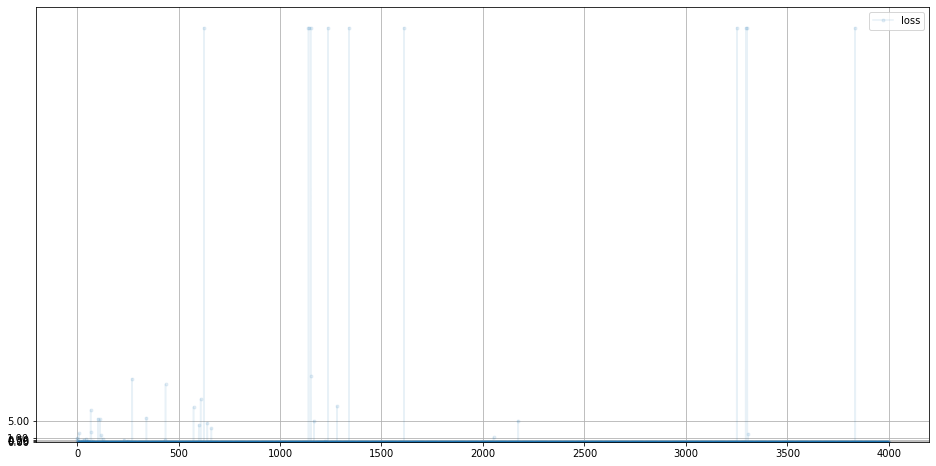

In [15]:
# D.plot_progress2()

In [19]:
# for i in range(4):
#   image_data_tensor = celeba_dataset[random.randint(0, 20000)]
#   print(D.forward(image_data_tensor).item())
#   pass

# for i in range(4):
#   print( D.forward( generate_random_image((1,3,128,128))).item())
#   pass

1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0


## 생성기

In [20]:
class Generator(nn.Module):
  
  def __init__(self):
    # 파이토치 부모 클래스 초기화
    super().__init__()

    # 신경망 레이어 정의
    self.model = nn.Sequential(
      # nn.Linear(100, 3*10*10),
      # nn.LeakyReLU(),
      # nn.LayerNorm(3*10*10),
      # nn.Linear(3*10*10, 3*218*178),
      # nn.Sigmoid(),
      # View((218,178,3))

      # 1차원 행렬 입력
      nn.Linear(100, 3*11*11),
      nn.LeakyReLU(0.2),
      # 4차원으로 형태 변환
      View((1,3,11,11)),

      nn.ConvTranspose2d(3, 256, kernel_size=8, stride=2),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(0.2),

      nn.ConvTranspose2d(256, 256, kernel_size=8, stride=2),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(0.2),

      nn.ConvTranspose2d(256, 3, kernel_size=8, stride=2, padding=1),
      nn.BatchNorm2d(3),

      nn.Sigmoid()
    )

    # SGD 옵티마이저 설정
    # self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
    self.optimiser = torch.optim.Adam(self.parameters(), lr=0.001)


    # 진행 측정을 위한 변수 초기화
    self.counter =0;
    self.progress = []


    pass

  def forward(self, inputs):
    #모델 실행
    return self.model(inputs)
  
  def train(self, D, inputs, targets):
    #신경망 출력 계산
    g_output = self.forward(inputs)

    #판별기로 전달
    d_output = D.forward(g_output)

    # 오차 계산
    loss = D.loss_function(d_output, targets)

    #카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1;
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass

    # 기울기를 초기화 하고 역전파 후 가중치 갱신
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass


  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    pass

  def plot_progress2(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
    pass

## 생성기 테스트

CPU times: user 22.4 ms, sys: 0 ns, total: 22.4 ms
Wall time: 30.1 ms


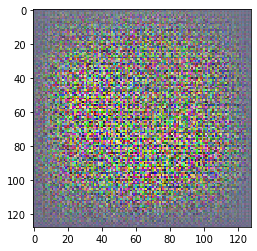

In [21]:
# %%time

# G = Generator()
# G.to(device)

# output = G.forward(generate_random_seed(100))
# img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()
# plt.imshow(img, interpolation='none', cmap='Blues')

## GAN 훈련

In [22]:
%%time

D = Discriminator()
D.optimiser.param_groups[0]['capturable'] = True
D.to(device)
G = Generator()
G.optimiser.param_groups[0]['capturable'] = True
G.to(device)

epochs = 1

for epoch in range(epochs):
  print("epoch = ", epoch + 1)

  for image_data_tensor in celeba_dataset:
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))
    pass

  pass

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
CPU times: user 13min 20s, sys: 4.82 s, total: 13min 24s
Wall time: 13min 26s


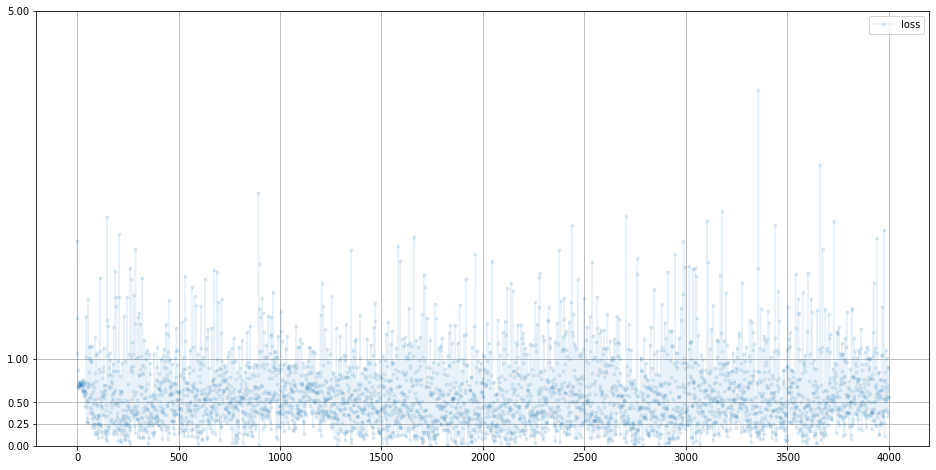

In [ ]:
D.plot_progress2()

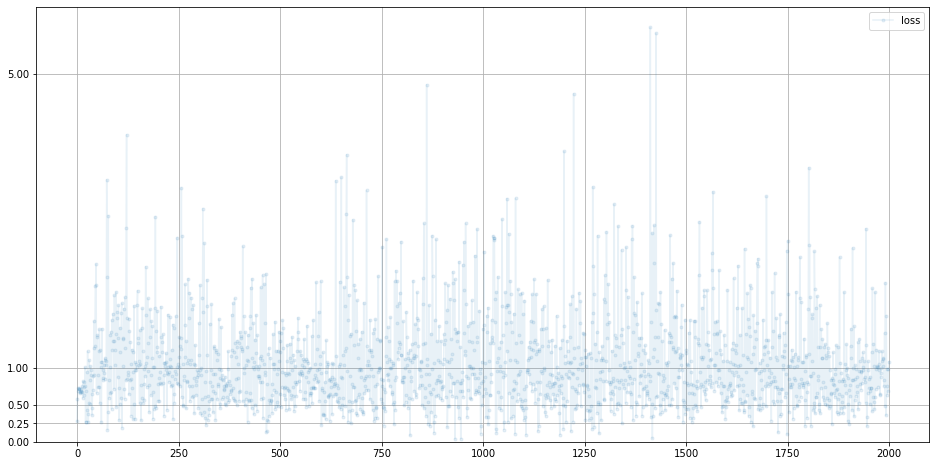

In [ ]:
G.plot_progress2()

## 훈련후 생성기 테스트

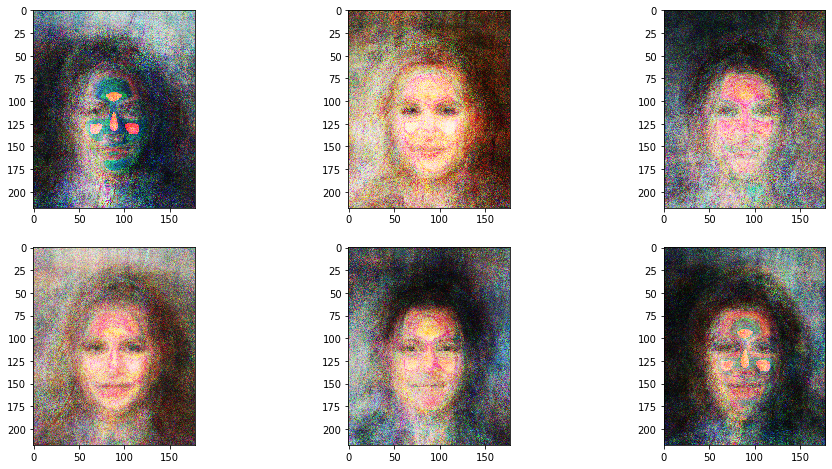

In [ ]:
f, axarr = plt.subplots(2,3,figsize=(16,8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random_seed(100))
    img = output.detach().cpu().numpy()
    axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
    pass
  pass